# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* National Hydrography Dataset (NHD) Plus for river network
* National Resources Conservation Service (NRCS) Soil Survey data for soil types
* National Land Cover Database (NLCD) for land cover/transpiration/rooting depths
* National Elevation Dataset (NED) for elevation/DEM

In [4]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [5]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import fiona
import rasterio

In [6]:
sys.path.append(os.path.abspath("/Users/shua784/Dropbox/github/watershed-workflow"))

In [7]:
import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)

In [11]:
# bnd_shp = '../data/hydrologic_units/others/hanford/subwatershed_boundary.shp'
bnd_shp = '../data/hydrologic_units/hanford/boundary_poly_v4.shp'
# bnd_shp = '../data/hydrologic_units/others/hanford/boundary_polygon_v3.shp'
river_shp = "../data/hydrologic_units/hanford/hanford_reach_extracted.shp"
fname_dem = "../data/hydrologic_units/hanford/topobathymetry_20200312_10m.tif"

## Import watershed boundary

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [12]:
# specify the input shapefile and a hint as to what HUC it is in.
logging.info("")
logging.info("Meshing shape: {}".format(bnd_shp))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(bnd_shp)

2020-08-25 13:11:20,602 - root - INFO: 
2020-08-25 13:11:20,603 - root - INFO: Meshing shape: ../data/hydrologic_units/hanford/boundary_poly_v4.shp
2020-08-25 13:11:20,604 - root - INFO: ==============================
2020-08-25 13:11:20,605 - root - INFO: 
2020-08-25 13:11:20,605 - root - INFO: Preprocessing Shapes
2020-08-25 13:11:20,606 - root - INFO: ------------------------------
2020-08-25 13:11:20,607 - root - INFO: loading file: "../data/hydrologic_units/hanford/boundary_poly_v4.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:331: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


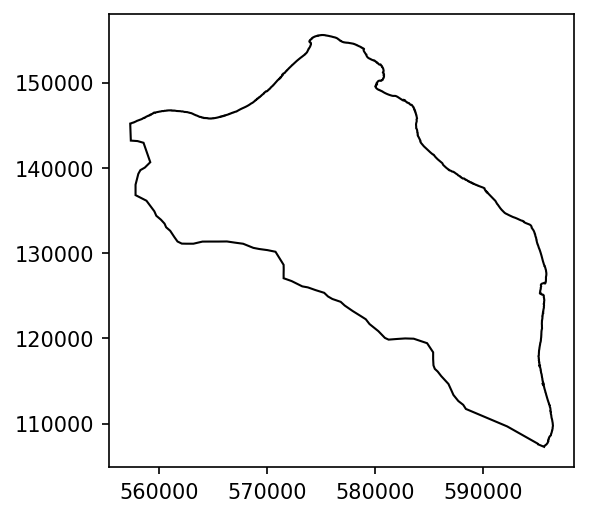

In [13]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [14]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2020-08-25 13:11:26,543 - root - INFO: Using sources:
2020-08-25 13:11:26,544 - root - INFO: --------------
2020-08-25 13:11:26,545 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2020-08-25 13:11:26,546 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2020-08-25 13:11:26,546 - root - INFO: DEM: National Elevation Dataset (NED)
2020-08-25 13:11:26,547 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-08-25 13:11:26,547 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-08-25 13:11:26,548 - root - INFO: soil thickness: None
2020-08-25 13:11:26,548 - root - INFO: meteorology: DayMet 1km


## import river shapes

### Option 1--bring your own shape

In [15]:
with fiona.open(river_shp, mode='r') as fid:
    profile = fid.profile
#     bounds = watershed.exterior().bounds
#     bounds_crs = workflow.crs.from_fiona(profile['crs'])
#     bounds = workflow.warp.bounds(bounds, bounds_crs, workflow.crs.from_fiona(profile['crs']))
    reaches = [r for (i,r) in fid.items()]

Watershed boundary and river must be in the same CRS.

In [16]:
# convert to destination crs
native_crs = workflow.crs.from_fiona(profile['crs'])
if crs and not workflow.crs.equal(crs, native_crs):
    for reach in reaches:
        workflow.warp.shape(reach, native_crs, crs)
else:
    crs = native_crs

**convert to shapely, and merge multiple reach segments into single rivers**

In [17]:
reaches_s = [workflow.utils.shply(reach) for reach in reaches]
rivers_s = list([shapely.ops.linemerge(shapely.geometry.MultiLineString(reaches_s))])

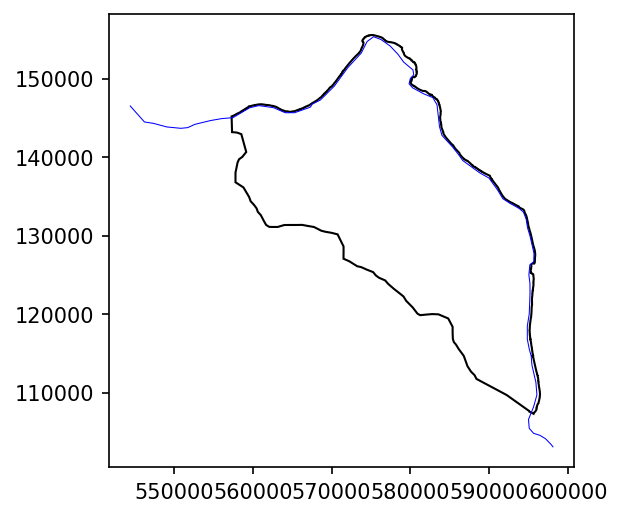

In [18]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(reaches_s, crs, ax=ax, color='red', linewidth=1)
x,y = rivers_s[0].xy
ax.plot(x,y, 'b', linewidth = 0.5)

In [19]:
logging.info("Generate the river tree")
rivers = workflow.hydrography.make_global_tree(rivers_s)

2020-08-25 13:11:57,050 - root - INFO: Generate the river tree


### Option 2--download river hydrography from NHD

In [13]:
simplify = 100 # length scale to target average edge
hint = '17020016'  # hint: HUC 4 containing this shape. This is necessary to avoid downloading all HUCs to search for this shape

has_rivers = True
if has_rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], hint, 
                                      watershed.exterior().bounds, crs, merge = True, presimplify=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [20]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 1000; d1 = 50000
# A0 = 50; A1 = 500000 # [6, 1000]m
A0 = 5000; A1 = 500000 # [70, 1000]m
# A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

2020-08-25 13:12:20,062 - root - INFO: 
2020-08-25 13:12:20,063 - root - INFO: Meshing
2020-08-25 13:12:20,063 - root - INFO: ------------------------------
2020-08-25 13:12:20,064 - root - INFO: Triangulating...
2020-08-25 13:12:20,117 - root - INFO:    17611 points and 17610 facets
2020-08-25 13:12:20,118 - root - INFO:  checking graph consistency


AssertionError: 

## Import DEM

### Bring your own DEM

In [101]:
logging.info("import dem from {}".format(fname_dem))
with rasterio.open(fname_dem, 'r') as fid:
    dem_profile = fid.profile
    dem = fid.read(1) # read the first band

2020-08-19 23:18:45,731 - root - INFO: import dem from ../data/hydrologic_units/others/hanford/topobathymetry_20200312_10m.tif


### Download DEM data from source

In [61]:
# get a raster for the elevation map
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2020-08-19 17:10:34,735 - root - INFO: 
2020-08-19 17:10:34,736 - root - INFO: Preprocessing Raster
2020-08-19 17:10:34,737 - root - INFO: ------------------------------
2020-08-19 17:10:34,738 - root - INFO: collecting raster
2020-08-19 17:10:35,039 - root - INFO: Collecting DEMs to tile bounds: [-119.76131861128867, 46.281832948286805, -119.23784239971664, 46.73891291085918]
2020-08-19 17:10:35,040 - root - INFO:   Need:
2020-08-19 17:10:35,041 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_1as_n47_w120.img
2020-08-19 17:10:35,941 - root - INFO: Attempting to download source for target '/Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_1as_n47_w120.img'
2020-08-19 17:10:35,942 - root - INFO: Downloading: "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/IMG/USGS_NED_1_n47w120_IMG.zip"
2020-08-19 17:10:35,943 - root - INFO:          to: "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/d

## elevate mesh to DEM

In [102]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile, algorithm='piecewise bilinear')

2020-08-19 23:19:00,833 - root - INFO: 
2020-08-19 23:19:00,834 - root - INFO: Elevating Triangulation to DEM
2020-08-19 23:19:00,835 - root - INFO: ------------------------------


### plot surface mesh

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

In [103]:
figsize = (6,6)
figsize_3d = (8,6)

[]

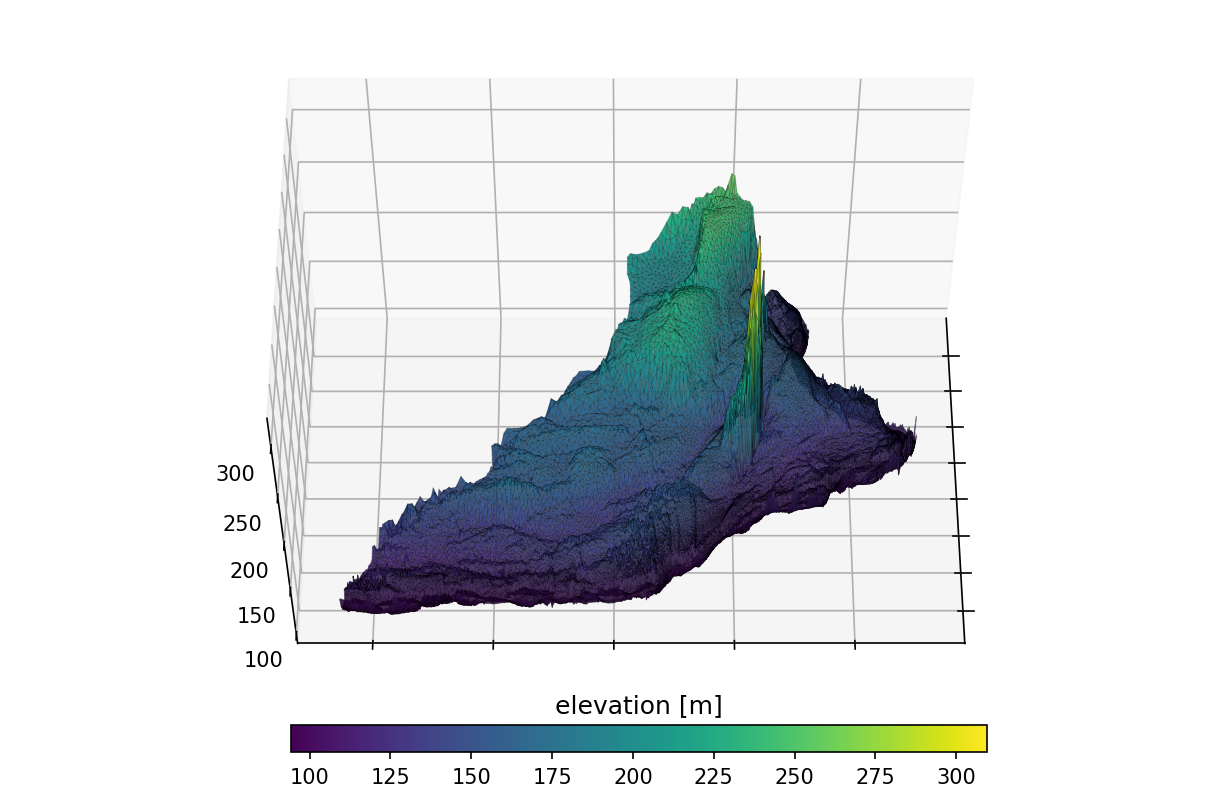

In [104]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

Text(0.5, 1.0, 'elevation [m]')

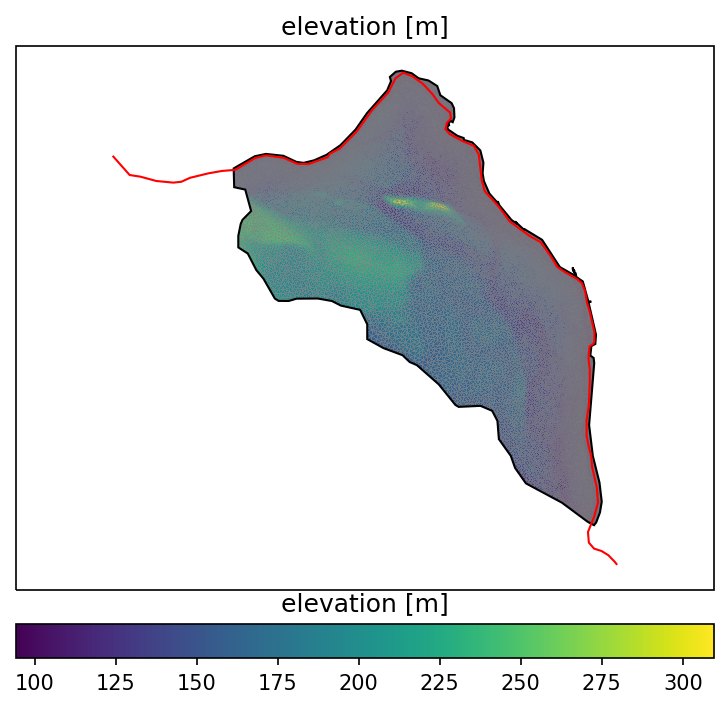

In [105]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='gray', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", pad=0.05)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
ax.set_title('elevation [m]')
cbar.ax.set_title('elevation [m]')
#fig.savefig('coweeta_dem')

### construct 2D mesh

In [106]:
m2 = workflow.mesh.Mesh2D(coords = mesh_points3.copy(), conn = list(mesh_tris))

### hydrologically conditioning the mesh in place by removing pits (optional)

In [36]:
workflow.condition.condition(m2)

In [ ]:
# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### export surface mesh to VTK

In [107]:
m2.write_VTK("./surface_mesh-70m.vtk")

## Surface properties: land cover (optional)

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [37]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2020-07-09 22:55:07,725 - root - INFO: 
2020-07-09 22:55:07,726 - root - INFO: Preprocessing Raster
2020-07-09 22:55:07,726 - root - INFO: ------------------------------
2020-07-09 22:55:07,727 - root - INFO: collecting raster
2020-07-09 22:55:07,735 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-07-09 22:55:07,853 - root - INFO: Got raster of shape: (199, 192)
2020-07-09 22:55:07,854 - root - INF

In [ ]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("land cover index")
fig.savefig('watershed_nlcd')

## Subsurface properties: soil type (optional)

Get soil structure from SSURGO

In [39]:
# download the NRCS soils data as shapes and project it onto the mesh
import workflow.sources.manager_nrcs
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
_, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

# -- log the bounds targetted and found
logging.info('target bounds: {}'.format(target_bounds))
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(soil_survey).bounds))

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['id'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2020-07-09 22:55:22,853 - root - INFO: 
2020-07-09 22:55:22,853 - root - INFO: Preprocessing Shapes
2020-07-09 22:55:22,853 - root - INFO: ------------------------------
2020-07-09 22:55:22,946 - root - INFO:   Using filename: /Users/shua784/Dropbox/github/watershed-workflow/examples/data/soil_survey/soil_survey_shape_-83.4790_35.0269_-83.4208_35.0743.gml
2020-07-09 22:55:22,985 - root - INFO:   Found 460 shapes.
2020-07-09 22:55:22,985 - root - INFO:   and crs: {'init': 'epsg:4326'}
2020-07-09 22:56:08,459 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-07-09 22:56:08,890 - root - INFO: shape union bounds: (272780.41575804196, 3877673.167325338, 281292.5042037172, 3887703.7251368817)
2020-07-09 22:56:08,891 - root - INFO: Coloring shapes onto raster:
2020-07-09 22:56:08,892 - root - INFO:   target_bounds = (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2020-07-09 22:56:08,892 - root - INF

In [ ]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0.5, color=soil_color, cmap='copper')
ax.set_title('soil type index')

fig.savefig('watershed_soils')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [151]:
ele_per_layer = mesh_tris.shape[0]

In [41]:
dz=0.1
tele = 1.1 # increment factor
tckness = [np.around(dz*tele**(i), decimals=2) for i in np.arange(49)]
# + np.repeat(5, 1, axis=0).tolist()

mat_ids = np.arange(1, len(tckness)+1) # layer ids

In [155]:
layer_types = ['constant'] * len(tckness)
layer_data = tckness
layer_ncells = [1] * len(tckness)
layer_mat_ids = [np.array([i]*ele_per_layer, dtype=int) for i in mat_ids]

In [41]:
# layer extrusion
# -- data structures needed for extrusion
# layer_types = []
# layer_data = []
# layer_ncells = []
# layer_mat_ids = []
# z = 0.0

# # -- soil layer --
# #  top 6 m
# #  5 cm initial top cell
# #  10 cells
# #  expanding dz, growing with depth
# ncells = 9 # num of layers
# dz = 0.1 # top layer thickness
# layer_dz = 4 # thickness of total soil layer

# # get increment factor between 1x and 2x to fill a given layer. i.e.,  
# # find f so that z0 + z0*f + z0*f^2 + z0*f^3 + ... + z0*f^ncell <= layer_dz
# tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
# logging.info("Got telescoping factor: {}".format(tele))

# for i in range(ncells):
#     layer_types.append('constant')
#     layer_data.append(dz)
#     layer_ncells.append(1)
#     layer_mat_ids.append(soil_color)
#     z += dz
#     dz *= tele
       
# # one more 2m layer makes 6m
# dz = 2.0
# layer_types.append('constant')
# layer_data.append(dz)
# layer_ncells.append(1)
# layer_mat_ids.append(soil_color)
# z += dz

# # -- geologic layer --
# # keep going for 2m cells until we hit the bottom of
# # the domain
# layer_types.append("constant")
# layer_data.append(40 - z) # depth of bottom of domain is 40 m
# layer_ncells.append(int(round(layer_data[-1] / dz)))
# layer_mat_ids.append(999*np.ones_like(soil_color))

In [158]:
# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2020-08-20 00:12:32,184 - root - INFO: Cell summary:
2020-08-20 00:12:32,185 - root - INFO: ------------------------------------------------------------
2020-08-20 00:12:32,186 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-08-20 00:12:32,186 - root - INFO: ------------------------------------------------------------
2020-08-20 00:12:32,186 - root - INFO:  00 	| 00 	|    1 	|   0.100000 	|   0.000000
2020-08-20 00:12:32,187 - root - INFO:  01 	| 01 	|    2 	|   0.110000 	|   0.100000
2020-08-20 00:12:32,187 - root - INFO:  02 	| 02 	|    3 	|   0.120000 	|   0.210000
2020-08-20 00:12:32,187 - root - INFO:  03 	| 03 	|    4 	|   0.130000 	|   0.330000
2020-08-20 00:12:32,188 - root - INFO:  04 	| 04 	|    5 	|   0.150000 	|   0.460000
2020-08-20 00:12:32,188 - root - INFO:  05 	| 05 	|    6 	|   0.160000 	|   0.610000
2020-08-20 00:12:32,189 - root - INFO:  06 	| 06 	|    7 	|   0.180000 	|   0.770000
2020-08-20 00:12:32,189 - root - INFO:  07 	| 07 	|    8 	|   0.190000 	|   0.9

In [159]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets

In [43]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

## export mesh file

In [160]:
# save to disk
try:
    os.remove('./meshes/hanford_mesh.exo')
except FileNotFoundError:
    pass
m3.write_exodus('./meshes/hanford_mesh.exo')


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: hanford_mesh.exo
Closing exodus file: hanford_mesh.exo
